In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
import os
import sys
import nltk

In [30]:
inter_target_folder = '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split'
extra_target_folder = '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split'

# The following 4 lists have to match so that the element at each index is correct
inter_target_folders = ['/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns']

extra_target_folders = ['/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns']

results_folders_extra = ['/Users/ff/results_20200303/results_extrapolation_100k/',
                         '/Users/ff/results_20200312/risk_full_20200312_extra/',
                         '/Users/ff/results_20200314/risk_full_20200314_extra/',
                         '/Users/ff/results_20200314_27000/risk_full_20200314_extra_27000/',
                         '/Users/ff/results_risk_len_20200323/risk_len_20200323_extra_37000/',
                         '/Users/ff/results_baseline_norm_tok_20200328/baseline_norm_tok_20200328_extra_96000/',
                         '/Users/ff/results_risk_irm_ns_20200328_27000/risk_irm_ns_20200328_extra_27000',
                         '/Users/ff/results_risk_irm_ns_20200328_40000/risk_irm_ns_20200328_extra_40000',
                         '/Users/ff/results_ns_20200316/ns_20200316_extra_96000']

results_folders_inter = ['/Users/ff/results_20200303/results_interpolation_100k/',
                         '/Users/ff/results_20200312/risk_full_20200312_inter/',
                         '/Users/ff/results_20200314/risk_full_20200314_inter/',
                         '/Users/ff/results_20200314_27000/risk_full_20200314_inter_27000/',
                         '/Users/ff/results_risk_len_20200323/risk_len_20200323_inter_37000/',
                         '/Users/ff/results_baseline_norm_tok_20200328/baseline_norm_tok_20200328_inter_96000/',
                         '/Users/ff/results_risk_irm_ns_20200328_27000/risk_irm_ns_20200328_inter_27000',
                         '/Users/ff/results_risk_irm_ns_20200328_40000/risk_irm_ns_20200328_inter_40000',
                         '/Users/ff/results_ns_20200316/ns_20200316_inter_96000']


checkpoints = [100000, 40000, 40000]

inter_targets = sorted(['algebra__polynomial_roots_tgt_test.txt',
                 'arithmetic__add_or_sub_tgt_test.txt',
                 'arithmetic__add_sub_multiple_tgt_test.txt',
                 'arithmetic__div_tgt_test.txt',
                 'arithmetic__mixed_tgt_test.txt',
                 'arithmetic__mul_div_multiple_tgt_test.txt',
                 'arithmetic__mul_tgt_test.txt',
                 'comparison__closest_tgt_test.txt',
                 'comparison__kth_biggest_tgt_test.txt',
                 'comparison__sort_tgt_test.txt',
                 'measurement__conversion_tgt_test.txt',
                 'numbers__place_value_tgt_test.txt',
                 'numbers__round_number_tgt_test.txt',
                 'probability__swr_p_level_set_tgt_test.txt',
                 'probability__swr_p_sequence_tgt_test.txt'])

extra_targets = sorted(['algebra__polynomial_roots_big_tgt_test.txt',
                 'arithmetic__add_or_sub_big_tgt_test.txt',
                 'arithmetic__add_sub_multiple_longer_tgt_test.txt',
                 'arithmetic__div_big_tgt_test.txt',
                 'arithmetic__mixed_longer_tgt_test.txt',
                 'arithmetic__mul_big_tgt_test.txt',
                 'arithmetic__mul_div_multiple_longer_tgt_test.txt',
                 'comparison__closest_more_tgt_test.txt',
                 'comparison__kth_biggest_more_tgt_test.txt',
                 'comparison__sort_more_tgt_test.txt',
                 'measurement__conversion_tgt_test.txt',
                 'numbers__place_value_big_tgt_test.txt',
                 'numbers__round_number_big_tgt_test.txt',
                 'probability__swr_p_level_set_more_samples_tgt_test.txt',
                 'probability__swr_p_sequence_more_samples_tgt_test.txt'])

In [31]:
def pair_files_in_folders(folders):
    res = {}
    for folder in sorted(folders):
        res[folder] = []
        for file in sorted(os.listdir(folder)):
            if file.endswith(".txt"):
                res[folder].append(os.path.join(folder, file))
    return res

In [32]:
extra_files = pair_files_in_folders(results_folders_extra)
inter_files = pair_files_in_folders(results_folders_inter)

In [33]:
def compute_accuracies(ref_lines, hyp_lines):
    bleus = np.zeros(len(ref_lines))
    accs = np.zeros(len(ref_lines))

    # https://www.nltk.org/_modules/nltk/translate/bleu_score.html
    smoothing_function = nltk.translate.bleu_score.SmoothingFunction().method1
    
    for i, (ref_line, hyp_line) in enumerate(zip(ref_lines, hyp_lines)):
        ref = ref_line.strip().split(' ')
        refs = [ref]
        hyp = hyp_line.strip().split(' ')
        #bleu = nltk.translate.bleu_score.sentence_bleu(refs, hyp, smoothing_function=smoothing_function)
        #bleus[i] = bleu
        accs[i] = (1 if np.array_equal(ref,hyp) else 0)

    #list_of_references = [[s.strip().split(' ')] for s in ref_lines]
    #hypotheses = [s.strip().split(' ') for s in hyp_lines]
    #corpus_bleu = nltk.translate.bleu_score.corpus_bleu(list_of_references, hypotheses)

    return (accs)#, bleus, corpus_bleu


def plot_accuracies(targets, targets_folders, hyp_files, title):
    plt.figure(figsize=(13,3))
    plt.tight_layout()
    plt.title(title)
    colors = ['b', 'g', 'r', 'y', ]
    
    bars = []
    bar_width = 1 / (len(hyp_files) + 1)
    for i in range(len(hyp_files)):
        bars.append(np.arange(len(targets)) + bar_width * i)

    accuracies = np.zeros(len(hyp_files))    
    n_sentences = 0
    
    for i, t in enumerate(targets):
        prev_target = ''
        
        for j,key in enumerate(sorted(hyp_files.keys())):
            target = os.path.join(targets_folders[j], t)
            
            # Avoid loading targets too many times
            if target != prev_target:
                prev_target = target
                with open(target, 'r') as f:
                    ref_lines = f.readlines()
                    n_sentences = len(ref_lines)
                    
            # Read files
            with open(os.path.join(hyp_files[key][i]), 'r') as f:
                hyp_lines = f.readlines()
                
            accs = compute_accuracies(ref_lines, hyp_lines)
            #print(hyp_files[key][i], accs.mean())
            plt.bar(bars[j][i], accs.mean(), color=get_cmap('tab10').colors[j], width=bar_width, alpha=0.7)
            
            accuracies[j] += accs.sum()
            
    plt.xticks(bars[len(bars)//2], targets, rotation='vertical')

    plt.legend([os.path.basename(os.path.normpath(p)) for p in sorted(hyp_files.keys())], 
               fontsize=9,
               bbox_to_anchor=(0.0, 1.01))
    plt.show()
    
    tot_sentences = n_sentences * len(targets)
    
    for i, p in enumerate(sorted(hyp_files.keys())):
        print(f'{os.path.basename(os.path.normpath(p))} - {accuracies[i] / tot_sentences}')


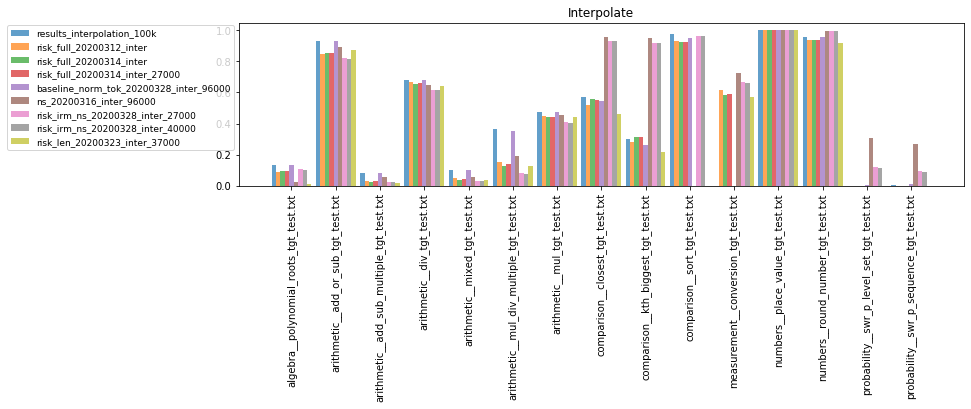

results_interpolation_100k - 0.4386333333333333
risk_full_20200312_inter - 0.43794666666666665
risk_full_20200314_inter - 0.43686
risk_full_20200314_inter_27000 - 0.4385133333333333
baseline_norm_tok_20200328_inter_96000 - 0.4323
ns_20200316_inter_96000 - 0.50156
risk_irm_ns_20200328_inter_27000 - 0.5195466666666667
risk_irm_ns_20200328_inter_40000 - 0.5160733333333334
risk_len_20200323_inter_37000 - 0.35456666666666664


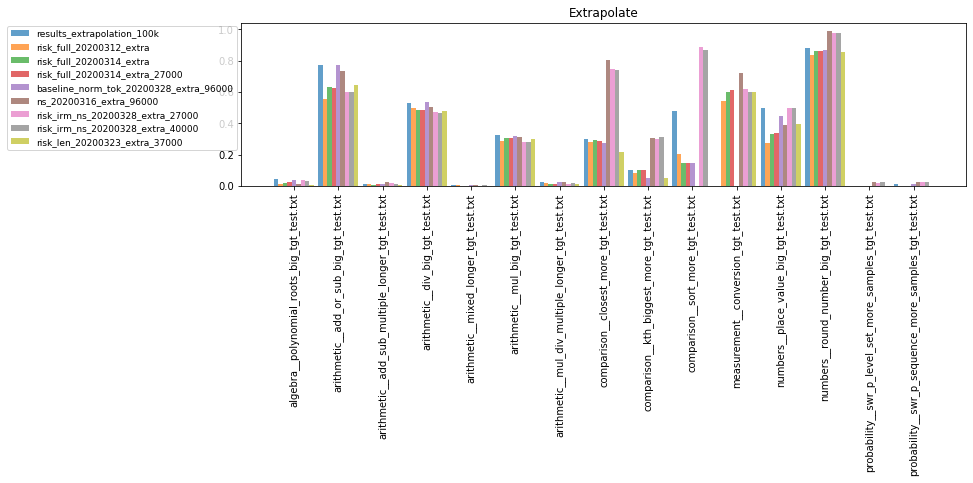

results_extrapolation_100k - 0.2658333333333333
risk_full_20200312_extra - 0.24062
risk_full_20200314_extra - 0.25322
risk_full_20200314_extra_27000 - 0.25527333333333335
baseline_norm_tok_20200328_extra_96000 - 0.23411333333333334
ns_20200316_extra_96000 - 0.32576666666666665
risk_irm_ns_20200328_extra_27000 - 0.36705333333333334
risk_irm_ns_20200328_extra_40000 - 0.3646
risk_len_20200323_extra_37000 - 0.23694


In [34]:
plot_accuracies(inter_targets, inter_target_folders, inter_files, title='Interpolate')
plot_accuracies(extra_targets, extra_target_folders, extra_files, title='Extrapolate')